In [42]:
from scipy import sparse as sp
from matplotlib import pyplot as plt
import numpy as np

default_dtype = np.complex128

In [43]:
Id = sp.csr_matrix(np.eye(2), dtype=default_dtype)
Sx = sp.csr_matrix([[0., 1.], [1., 0.]], dtype=default_dtype)
Sz = sp.csr_matrix([[1., 0.], [0., -1.]], dtype=default_dtype)
Splus = sp.csr_matrix([[0., 1.], [0., 0.]], dtype=default_dtype)
Sminus = sp.csr_matrix([[0., 0.], [1., 0.]], dtype=default_dtype)


def singlesite_to_full(op, i, L):
    op_list = [Id]*L  # = [Id, Id, Id ...] with L entries
    op_list[i] = op
    full = op_list[0]
    for op_i in op_list[1:]:
        full = sp.kron(full, op_i, format="csr")
    return full


def gen_sx_list(L):
    return [singlesite_to_full(Sx, i, L) for i in range(L)]


def gen_sz_list(L):
    return [singlesite_to_full(Sz, i, L) for i in range(L)]


def gen_hamiltonian(sx_list, sz_list, g, J=1.):
    L = len(sx_list)
    H = sp.csr_matrix((2**L, 2**L), dtype=default_dtype)
    for j in range(L):
        H = H - J *( sx_list[j] * sx_list[(j+1)%L])
        H = H - g * sz_list[j]
    return H

def gen_hamiltonian_L(L: int, g: float, J: float = 1.0) -> sp.csr_matrix:
    return gen_hamiltonian(gen_sx_list(L), gen_sz_list(L), g, J)

In [44]:
L = 14
g = 1.5
J = 1.0
H = gen_hamiltonian_L(L=L, g=g, J=J)
E0, psi_0 = sp.linalg.eigsh(H, k=1, which="SA")
psi_0 = psi_0.flatten()

In [45]:
assert np.allclose(np.linalg.norm(psi_0), [1.0])
assert psi_0.shape == (2**L,)

In [46]:
def i_state(i: int, L: int) -> np.ndarray:
    out = np.empty(L, dtype=bool)
    for j in range(L):
        out[j] = i & (1 << j)
    return out.astype(default_dtype)[::-1]

# test
assert np.all(i_state(int("01011", 2), 5) == np.array([0, 1, 0, 1, 1]))

In [47]:
psi = np.zeros(L, dtype=default_dtype)
for i, psi_i in enumerate(psi_0):
    psi += psi_i * i_state(i, L)
print(psi)

[-2.14855426-2.30731836j -2.14855426-2.30731836j -2.14855426-2.30731836j
 -2.14855426-2.30731836j -2.14855426-2.30731836j -2.14855426-2.30731836j
 -2.14855426-2.30731836j -2.14855426-2.30731836j -2.14855426-2.30731836j
 -2.14855426-2.30731836j -2.14855426-2.30731836j -2.14855426-2.30731836j
 -2.14855426-2.30731836j -2.14855426-2.30731836j]


In [48]:
psi_ab = np.reshape(psi_0, (2**(L//2), 2**(L//2)))

# check if we can recreate the same psi
psi_test = np.zeros(L, dtype=default_dtype)
for a in range(2**(L//2)):
    for b in range(2**(L//2)):
        psi_test += psi_ab[a, b] * np.concatenate((i_state(a, L//2), i_state(b, L//2)), axis=0)

assert np.allclose(psi, psi_test)
del psi_test

In [49]:
u, lambdas, vh = np.linalg.svd(psi_ab)

assert np.allclose(psi_ab, u @ np.diag(lambdas) @ vh)

In [55]:
def get_lambdas(psi: np.ndarray, L: int) -> np.ndarray:
    _psi = psi.copy()
    if len(_psi.shape) == 1:
        _psi = _psi.reshape((2**(L//2), 2**(L//2))) 
    _, lambdas, _ = np.linalg.svd(_psi)
    return lambdas

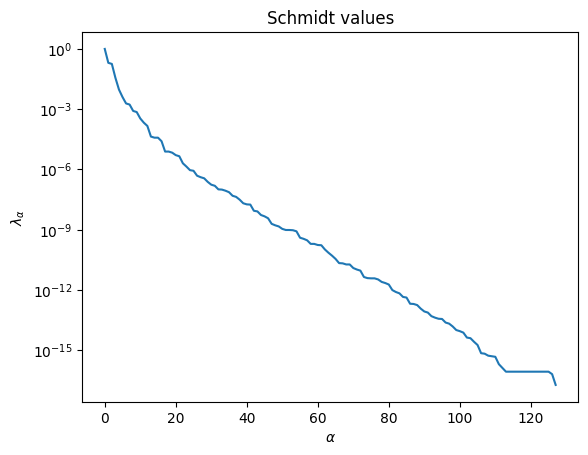

In [51]:
plt.figure()
plt.plot(lambdas)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\lambda_\\alpha$")
plt.title("Schmidt values")
plt.yscale("log")
plt.show()

In [52]:
def get_random_state(L: int) -> np.ndarray:
    state = np.random.normal(size=(2**L)) + 1j * np.random.normal(size=(2**L))
    state /= np.linalg.norm(state)
    return state

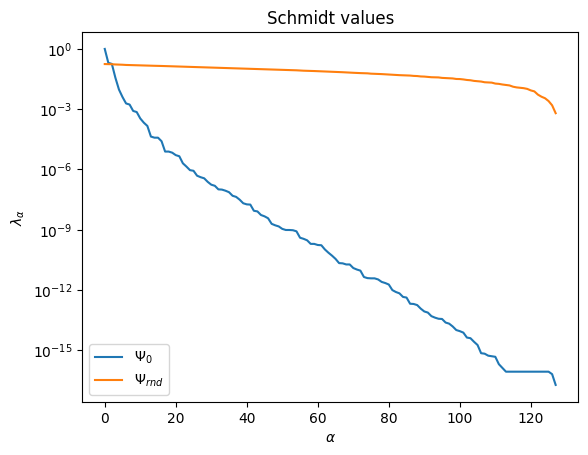

In [56]:
plt.figure()
plt.plot(lambdas, label="$\\Psi_0$")
plt.plot(get_lambdas(get_random_state(L), L), label="$\\Psi_{rnd}$")
plt.xlabel("$\\alpha$")
plt.ylabel("$\\lambda_\\alpha$")
plt.title("Schmidt values")
plt.yscale("log")
plt.legend()
plt.show()

In [54]:
def entanglement_entropy(lambdas: np.ndarray) -> float:
    return - np.sum(lambdas**2 * np.log(lambdas**2))

In [71]:
def print_entropy(g: float, L: int, psi = None) -> float:
    if psi is None:
        H = gen_hamiltonian_L(L=L, g=g, J=J)
        _, psi = sp.linalg.eigsh(H, k=1, which="SA")
        psi = psi.flatten()
    lambdas = get_lambdas(psi, L)
    S = entanglement_entropy(lambdas)
    print(f"{g = }, {L = }: {S = :.3f}, theoretical for random state: {L/2 * np.log(2) - 0.5}")
    return S

In [72]:
Ls = [6, 8, 10, 12, 14]
for L in Ls:
    print_entropy(g=1.5, L=L)
    print_entropy(g=1.0, L=L)
    print_entropy(g=0.5, L=L)
    print_entropy(g="random", L=L, psi=get_random_state(L))

g = 1.5, L = 6: S = 0.313, theoretical for random state: 1.5794415416798357
g = 1.0, L = 6: S = 0.588, theoretical for random state: 1.5794415416798357
g = 0.5, L = 6: S = 0.697, theoretical for random state: 1.5794415416798357
g = 'random', L = 6: S = 1.658, theoretical for random state: 1.5794415416798357
g = 1.5, L = 8: S = 0.312, theoretical for random state: 2.272588722239781
g = 1.0, L = 8: S = 0.635, theoretical for random state: 2.272588722239781
g = 0.5, L = 8: S = 0.699, theoretical for random state: 2.272588722239781
g = 'random', L = 8: S = 2.269, theoretical for random state: 2.272588722239781
g = 1.5, L = 10: S = 0.310, theoretical for random state: 2.9657359027997265
g = 1.0, L = 10: S = 0.672, theoretical for random state: 2.9657359027997265
g = 0.5, L = 10: S = 0.699, theoretical for random state: 2.9657359027997265
g = 'random', L = 10: S = 2.969, theoretical for random state: 2.9657359027997265
g = 1.5, L = 12: S = 0.309, theoretical for random state: 3.6588830833596